In [1]:
import pandas as pd
from sqlalchemy import create_engine,Inspector,text
import json
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import reliability.Fitters as F
import reliability.Distributions as D
from datetime import datetime as dt
from sqlalchemy import text
import os 
today = dt.today().strftime('%Y-%m-%d')

plt.rcParams['font.family'] = 'SimHei'  # 替换为你选择的字体
today = dt.today().strftime('%Y-%m-%d')

In [2]:
# 定义数据库连接信息
db_username = 'develop'
db_password = 'Dev&168!'
db_port = '3306'
# db_hostname = '172.24.139.117'
# db_name = 'zlaq_gd_ana'

In [3]:
db_name = 'zlaq_prod'
db_hostname = '172.24.139.206'

# 创建数据库连接字符串
db_connection_str = f'mysql+pymysql://{db_username}:{db_password}@{db_hostname}:{db_port}/{db_name}'

# 创建数据库连接引擎
engine = create_engine(db_connection_str)
inspector = Inspector.from_engine(engine)
tables = inspector.get_table_names()

C:\Users\zhoufeng7\AppData\Local\Temp\ipykernel_12836\2084192754.py:9: SADeprecationWarning: The from_engine() method on Inspector is deprecated and will be removed in a future release.  Please use the sqlalchemy.inspect() function on an Engine or Connection in order to acquire an Inspector. (deprecated since: 1.4)
  inspector = Inspector.from_engine(engine)


In [4]:
### 索赔单

claims_sql = '''
select * from
(select claim_guarantee_code,vin,guarantee_amount,
delivery_time,fault_time,tech_code,
driving_mileage,
damage_material_code,damage_material_name,guarantee_type,material_total_amount,
vehicle_category_code,LEFT(vehicle_category_code,3) as vehicle_cate_merge,
usage_type_name
 from dwd_aftersale_claim_guarantee_order_df
where 1=1 
    and damage_material_code = 'X01-30090011'
    and guarantee_type = 10
) raw
where 1=1 
and vehicle_cate_merge in ('X01','X02')
'''

In [6]:
#claims_raw = pd.read_sql(text(claims_sql), engine)
claims_raw = pd.read_clipboard()
#https://li.feishu.cn/sheets/HMw9sozuehfcmtty1JIcbb7Snge?sheet=JPyjxb

# claims_raw = claims_raw.dropna()
# https://li.feishu.cn/sheets/BN8WsSkMyhE6dzt5gVjcJ8pinDb?sheet=8O672n


###里程
mils_query = '''
select vin,total_odometer from dm_vom_drive_total_sum_df 
'''
# dm_vom_adas_total_odometer  
# dm_vom_drive_total_sum_df
mils_raw = pd.read_sql(mils_query, engine)


###车辆
vehicle_query = '''
select vin,vehicle_series_category_code,vehicle_model_name,factory_name,year_size,
left(actual_product_finish_time,10) as product_date, left(product_delivery_time,10) as delivery_date,ad_platform_name
from dim_pro_prod_vehicle_base_info_df 
where 1=1 
and product_delivery_time is not null
-- and actual_product_finish_time >= '2023-10-01 00:00:00'
and actual_product_finish_time <= '2025-01-10 00:59:59'
and vehicle_series_category_code in ('X01','X02')
'''
vehicle_raw = pd.read_sql(vehicle_query, engine)
# vehicle_raw = pd.read_csv(os.path.join(r'D:\代码项目\WEIBULL\数据源','weiling_accm.csv'))
len(vehicle_raw)
# vehicle_raw = pd.read_excel(os.path.join(r'D:\代码项目\WEIBULL\数据源','四通阀问题精确追溯.xlsx'))
print(len(claims_raw))
print(len(vehicle_raw))


59
450780


56 450780


C:\Users\zhoufeng7\AppData\Local\Temp\ipykernel_12836\3620237340.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_data.sort_values('total_odometer',inplace=True)
C:\Users\zhoufeng7\AppData\Local\Temp\ipykernel_12836\3620237340.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_data.drop_duplicates('vin',keep='first',inplace=True)


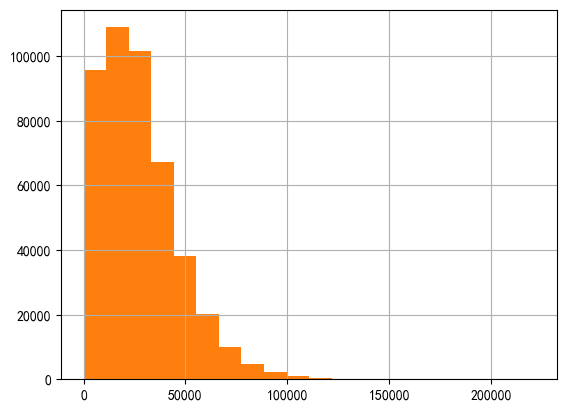

In [15]:
#assert 3>4
claims = claims_raw.copy()
vehicle = vehicle_raw.copy()

vehicle = vehicle.merge(mils_raw,on='vin')
# ['vin_use', 'vehicle_series_category_code', 'vehicle_category_code', 'vehicle_model_name', 'ticket_create_time', 'product_date', 'delivery_date', 'year_size', 'retail_store_province_name',
#        'total_travel_mileage', 'extracted_value', 'part_code', 'part_barcode', 'mil_1000', 'accum_total_mileage']

# claims = claims.loc[claims['guarantee_type']==10]
claims['vin'] = claims['VIN']
claims['total_odometer'] = claims['行驶里程']
failure_data = claims.loc[claims.vin.isin(vehicle.vin)]
failure_data['total_odometer'].hist(bins=20)
failure_data.sort_values('total_odometer',inplace=True)
failure_data.drop_duplicates('vin',keep='first',inplace=True)
# .loc[claims['ad_platform_name']=='AD MAX']
risk_data = vehicle

vehicle['total_odometer'].hist(bins=20)


print(len(failure_data),len(risk_data))

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 56/450722 (99.98758% right censored) 

Parameter  Point Estimate  Standard Error    Lower CI    Upper CI
    Alpha     3.20554e+06     1.29979e+06 1.44795e+06 7.09656e+06
     Beta         1.97049        0.186619     1.63666      2.3724 

Goodness of fit    Value
 Log-likelihood -1113.91
           AICc  2231.81
            BIC  2253.85
             AD  1488.24 



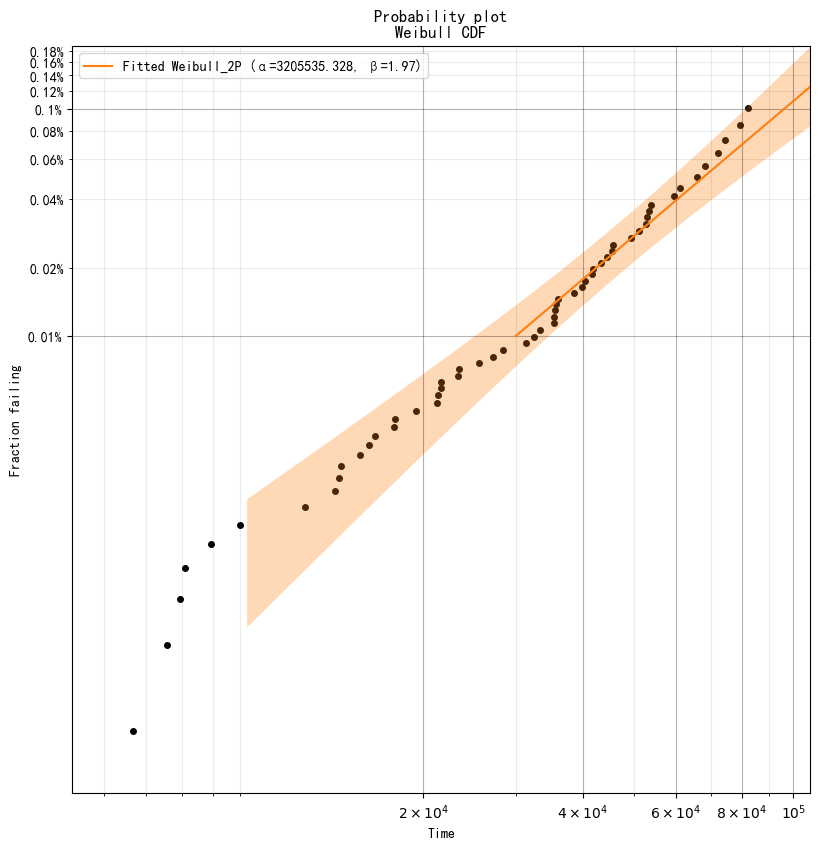

In [16]:
new_rate = len(failure_data.loc[failure_data['total_odometer']<=1000])/len(risk_data)

failure_data.total_odometer.hist(bins=20)
#risk_data.use_days.hist(bins=20)
output = F.Fit_Weibull_2P(
        failure_data.loc[failure_data['total_odometer']>1000,'total_odometer'].tolist(),
        right_censored = risk_data.loc[~risk_data.vin.isin(failure_data.vin)]['total_odometer'].tolist(),
        CI_type='reliability')


100000公里故障率在0.0737%到0.1576%之间，估计损失件在332到710之间。更高里程数据缺乏证据，仅作为参考。


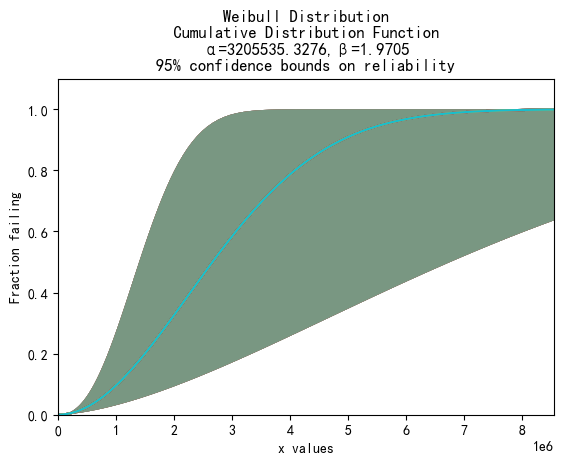

In [19]:
# new_rate = 0
out = pd.DataFrame()
out['total_odometer'] = [10000*i for i in range(1,11)]
# out['使用天数'] = [30 *(i+1)for i in range(96)]

out['平均(%)'] = out['total_odometer'].apply(lambda x : (1 - output.distribution.SF(x))*100) +new_rate*100
out['95%上限(%)']=  out['total_odometer'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[-1]*100) +new_rate*100
out['95%下限(%)']=  out['total_odometer'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[0]*100) +new_rate*100

out.to_clipboard(index=False)

miles = 100000
use = out.loc[out['total_odometer'] == miles]

rate_ = use.values.reshape(-1)[2:]
num_ = len(risk_data) * rate_/100 
print(f"{miles}公里故障率在{min(rate_) :.4f}%到{max(rate_) :.4f}%之间，估计损失件在{min(num_) :.0f}到{max(num_) :.0f}之间。更高里程数据缺乏证据，仅作为参考。")



In [ ]:
risk_data = pd.read_clipboard() 
# 32028
# https://li.feishu.cn/sheets/IZp0sTKC5hshcatRJ6zc0fd7n3b
vehicle_raw['vin'] = vehicle_raw['vin_use']
risk_data = risk_data.merge(vehicle_raw,on='vin',how='inner')

# 29478
misscar = 1 - 29478/32028


risk_data['use_days'] = pd.to_datetime('2024-11-26') - pd.to_datetime(risk_data['delivery_date'])
risk_data['use_days'] = risk_data['use_days'].dt.days


(risk_data['use_days']//30).value_counts().to_clipboard()
